In [25]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import random
from pyomo import environ as pe
import os
os.environ['NEOS_EMAIL'] = 'XXXX@gmail.com' 

In [26]:
df = pd.read_csv('numberlinkv2.csv')

df
data = {}
for row in range(len(df)):
    S= [s for s in df.loc[row,'Data'] ]
    D= {(row,c):S[c] for c in range(len(S)) }
    data.update(D)  
len(data)

64

In [27]:
loc = {}
n = 0 
for (r,c),v in data.items():
    n+=1
    loc[n,'x'] = r
    loc[n,'y'] = c
    loc[n,'v'] = v
    
dictintc = set([v for (r,c),v in data.items()])
dictintc.remove('.')

Nloc = {s:[] for s in dictintc}
nodes = range(1,len(data)+1)
for n in nodes:
    if loc[n,'v'] in Nloc:
        v =loc[n,'v']
        Nloc[v]+= [n]
Nloc

{'B': [5, 56],
 'I': [30, 64],
 'C': [11, 44],
 'E': [13, 15],
 'H': [29, 55],
 'F': [19, 50],
 'G': [27, 52],
 'A': [1, 4],
 'D': [12, 37]}

In [28]:
allowed = {}
for n in nodes:
    for m in nodes:
        con1 = abs(loc[n,'x']-loc[m,'x']) == 1
        con2 = abs(loc[n,'y']-loc[m,'y']) == 1 
        con3 = (abs(loc[n,'x']-loc[m,'x'])* abs(loc[n,'y']-loc[m,'y'])) == 0
        if (con1 or con2) and con3:
            allowed[n,m] = 1 

In [29]:
len(allowed), len(dictintc) , len(Nloc)*len(data)

(224, 9, 576)

In [30]:
N = len(nodes)
model = AbstractModel()
model.i = RangeSet(N)
model.j = Set(initialize=model.i)
model.S = Set(initialize=list(dictintc) )
model.flow = Var(model.i,model.j,model.S,bounds=(0,1), within = Reals)
model.source = Var(model.i,model.S,bounds=(0,1), within = Reals)
model.assign = Var(model.i,model.S, within = Binary)

def rule_C0(model,i):
    return  sum(model.assign[i,s] for s in model.S) <= 1 
model.C0 = Constraint(model.i, rule=rule_C0)

def rule_C1(model,i,s):
    return  model.source[i,s] - model.assign[i,s]/N == sum(model.flow[i,j,s]-model.flow[j,i,s] 
                                                           for j in model.j 
                                                           if (i,j) in allowed )
model.C1 = Constraint(model.i,model.S, rule=rule_C1)


def rule_C2A(model,i,j,s):
    if (i,j) in allowed:
        return  model.flow[i,j,s] <= model.assign[i,s] 
    else:
        return Constraint.Skip
model.C2A = Constraint(model.i,model.j, model.S, rule=rule_C2A)

def rule_C2B(model,i,j,s):
    if (i,j) in allowed:
        return  model.flow[i,j,s] <= model.assign[j,s] 
    else:
        return Constraint.Skip
model.C2B = Constraint(model.i,model.j, model.S, rule=rule_C2B)


def rule_of(model):
    return sum(model.assign[i,s] for i in model.i for s in model.S)

In [32]:
model.obj = Objective(rule=rule_of, sense=minimize)
instance = model.create_instance()
for i in instance.i:
    for s in instance.S:
        if i in Nloc[s]:
            instance.assign[i,s].fix(1)  
        if i != Nloc[s][0]:
            instance.source[i,s].fix(0)
        #"""
opt = SolverFactory('cbc')
opt.options = {'sec': 600, 'threads': 4, 'ratio': 0.2}
#opt = pe.SolverManagerFactory('neos')
#results = opt.solve(instance, solver = "cplex", options={'mipgap':0.15})
results = opt.solve(instance)  

    'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This
    is usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


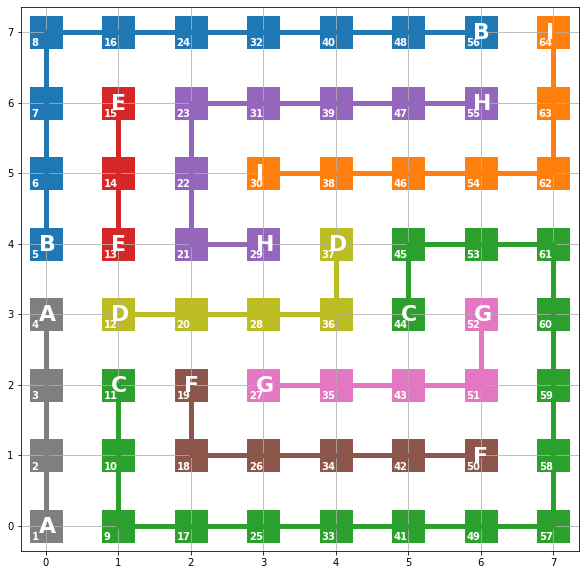

In [34]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
            "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
            "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
            "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
            "#8c6d31", "#9c9ede", "#637939", "#e7cb94", "#b5cf6b",
            "#cedb9c", "#c7c7c7", "#bd9e39", "#e7969c", "#7b4173"]

names = [s for s in instance.S]
plt.figure(figsize=(10,10))
plt.grid()
for s in instance.S:    
    for (i,j) in allowed:
        if value(instance.flow[i,j,s])>0:
            #print(value(instance.assign[i,s]) ,value(instance.assign[j,s]) )
            x1,y1 = loc[i,'x'], loc[i,'y']
            x2,y2 = loc[j,'x'], loc[j,'y']
            indx=names.index(s)
            plt.plot([x1,x2],[y1,y2], c=colors[indx], lw=5 )
            plt.scatter(x1,y1,s=1000, marker= 's', c=colors[indx])
            plt.scatter(x2,y2,s=1000, marker= 's', c=colors[indx])
for i in instance.i:
    x1,y1 = loc[i,'x'], loc[i,'y']
    plt.text(x1-0.2,y1-0.2, s=str(i), fontweight='bold', fontsize=10, c='w')
    for s in instance.S:
        if i in Nloc[s]:
            x1,y1 = loc[i,'x'], loc[i,'y']
            plt.text(x1-0.1,y1-0.1, s=s, fontweight='bold', fontsize=22, c='w')